### Imports And Constants

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from torchvision import transforms as tr
from torchvision.transforms import Compose
from torchvision import models, datasets

from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [2]:
IMG_SIZE = (64, 64)
IMG_ARR_SIZE = IMG_SIZE[0] * IMG_SIZE[1]
MAX_IMGS = 10000
CLASSES = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']
SEED = 42

### Extarct All Images

In [3]:
def extract_images_from_path(imgs_path_label, train_val_dir, dir_ori='data_0'):
    path = os.path.join(dir_ori, train_val_dir)
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            if filename.endswith('.png'):
                label = dirpath.split('/')[2]
                img_path = os.path.join(dirpath, filename)
                imgs_path_label[img_path] = label
    return imgs_path_label

In [4]:
def extract_all_images():
    return extract_images_from_path(extract_images_from_path({}, 'train'), 'val')

In [5]:
imgs_path_label = extract_all_images()

### Exploration

In [6]:
def create_hist(labels, count):
    plt.bar(hist_labels.keys(), hist_labels.values(), color='maroon', width=0.4)
 
    plt.xlabel("Class")
    plt.ylabel("Class' Count")
    plt.title("Classes Histogram")
    plt.show()

{'i': 239, 'ii': 141, 'iii': 129, 'iv': 245, 'v': 165, 'vi': 156, 'vii': 155, 'viii': 158, 'ix': 200, 'x': 169}


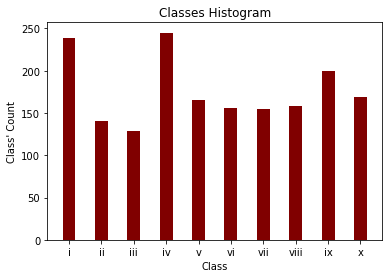

In [7]:
hist_labels = {c: list(imgs_path_label.values()).count(c) for c in CLASSES}
print(hist_labels)
create_hist(hist_labels.keys(), hist_labels.values())

### Split To Train-Validation

In [8]:
# # self evaluation
# X_train_val_path, X_test_path, y_train_val, y_test_ori = model_selection.train_test_split(list(imgs_path_label.keys()), list(imgs_path_label.values()), test_size=0.2, stratify=list(imgs_path_label.values()), random_state=SEED)
# X_train_path, X_val_path, y_train_ori, y_val_ori = model_selection.train_test_split(X_train_val_path, y_train_val, test_size=0.2, stratify=y_train_val, random_state=SEED)

In [9]:
# final submission
X_train_path, X_val_path, y_train_ori, y_val_ori = model_selection.train_test_split(list(imgs_path_label.keys()), list(imgs_path_label.values()), test_size=0.2, stratify=list(imgs_path_label.values()), random_state=SEED)

### Augmentation

In [10]:
pipeline_0 = Compose(
             [tr.Resize(IMG_SIZE),
              tr.ToTensor()])

In [11]:
def custom_transform(X_paths, y_ori, base_pipeline=pipeline_0, pipeline=None, num_of_imgs=1):
    if type(num_of_imgs) == dict:
        X = torch.Tensor(num_of_imgs['total'], IMG_SIZE[0], IMG_SIZE[1])
    else:
        X = torch.Tensor(len(X_paths) * num_of_imgs, IMG_SIZE[0], IMG_SIZE[1])
    y = []
    
    counter = 0
    for i, (img_path, label) in enumerate(zip(X_paths, y_ori)):
        img = Image.open(img_path)
        new_imgs = [base_pipeline(img = img)[0]]
        if type(num_of_imgs) == dict:
            if num_of_imgs[label] > 1:
                new_imgs.extend([pipeline(img = img)[0] for _ in range(num_of_imgs[label]-1)])
                X[counter : counter + num_of_imgs[label]] = torch.stack(new_imgs)
                y.extend([label] * num_of_imgs[label])
                counter += num_of_imgs[label]
        else:
            new_imgs.extend([pipeline(img = img)[0] for _ in range(num_of_imgs-1)])
            X[counter : counter + num_of_imgs] = torch.stack(new_imgs)
            y.extend([label] * num_of_imgs)
            counter += num_of_imgs    
    return X, y

In [12]:
pipeline_1 = Compose(
             [tr.Resize(IMG_SIZE),
              tr.RandomPerspective(distortion_scale=0.5, p=1.0, fill=255),
              tr.ColorJitter(brightness=0.5),
              tr.ToTensor()])

In [13]:
# class_num_imgs = (MAX_IMGS - len(y_val_ori) - len(y_test_ori)) / len(CLASSES)
class_num_imgs = (MAX_IMGS - len(y_val_ori)) / len(CLASSES)
hist_labels = {c: y_train_ori.count(c) for c in CLASSES}
num_of_imgs = {c: int(class_num_imgs / hist_labels[c]) for c in CLASSES}
num_of_imgs['total'] = sum([num_of_imgs[c] * hist_labels[c] for c in CLASSES])
complete_counter = {c: int(class_num_imgs) - (num_of_imgs[c] * hist_labels[c]) for c in CLASSES}

X_train, y_train = custom_transform(X_train_path, y_train_ori, pipeline=pipeline_1, num_of_imgs=num_of_imgs)
X_val, y_val = custom_transform(X_val_path, y_val_ori)
# X_test, y_test = custom_transform(X_test_path, y_test_ori)

{'i': 955, 'ii': 904, 'iii': 927, 'iv': 784, 'v': 924, 'vi': 875, 'vii': 868, 'viii': 882, 'ix': 960, 'x': 945}


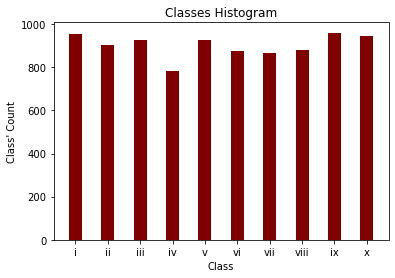

In [14]:
hist_labels = {c: y_train.count(c) for c in CLASSES}
print(hist_labels)
create_hist(hist_labels.keys(), hist_labels.values())

### Save Tensor As PNG Files

In [15]:
def save_images(train_val_dir, images, labels, dir_name='data'):
    os.makedirs(dir_name, exist_ok=True)
    
    train_val_path = os.path.join(dir_name, train_val_dir)
    os.makedirs(train_val_path , exist_ok=True)
    
    for c in CLASSES:
        class_dir_path = os.path.join(train_val_path, c)
        os.makedirs(class_dir_path , exist_ok=True)
    
    for i, (img, label) in enumerate(zip(images, labels)):
        label_dir_path = os.path.join(train_val_path, label)
        tr.ToPILImage()(img).save(os.path.join(label_dir_path, str(i) + '.png'))

In [16]:
save_images('train', X_train, y_train)

In [17]:
save_images('val', X_val, y_val)

In [18]:
# save_images('test', X_test, y_test, dir_name='data_test')

### Evaluation

In [ ]:
!python /home/student/run_train_eval.py

In [21]:
def test_accuracy(model_path='trained_model.pt', dir_name='data_test', base_pipeline=pipeline_0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model_ft = models.resnet50(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(CLASSES))
    model_ft = model_ft.to(device)
    model_ft.load_state_dict(torch.load(model_path))
    model_ft.eval()

    test_dir = os.path.join(dir_name, "test")
    test_dataset = datasets.ImageFolder(test_dir, base_pipeline)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

    counter = 0
    correct = 0
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)

        counter += 1
        if torch.sum(preds == labels.data):
            correct += 1

    print('Test Accuracy: ' + str((correct/counter)*100) + '%')


In [ ]:
test_accuracy()